# Flight Delay Prediction

This notebook aims to predict flight departure and arrival delays using a linear regression model. We'll explore the dataset, preprocess the data, train models, and evaluate their performance.

In [23]:
import pandas as pd
import pickle
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## Loading the Dataset

We start by loading the cleaned dataset, which contains flight and weather-related features.

In [13]:
print("📦 Loading dataset...")
df = pd.read_csv("data/processed/df_cleaned_ready_for_modeling.csv")
df.head()

📦 Loading dataset...


,FlightDate,Day_Of_Week,Airline,Dep_Airport,DepTime_label,Dep_Delay,Arr_Airport,Arr_Delay,Flight_Duration,Distance_type,...,tmin,tmax,prcp,snow,wdir,wspd,pres,Cancelled,Diverted,Aircraft_Age_Group
0,2023-01-02,1,Endeavor Air,BDL,Morning,-3,LGA,-12,56,Short Haul >1500Mi,...,-2.1,8.3,0.0,0.0,338.0,3.2,1019.1,0,0,"[10, 20)"
1,2023-01-03,2,Endeavor Air,BDL,Morning,-5,LGA,-8,62,Short Haul >1500Mi,...,-1.6,4.4,10.7,0.0,3.0,3.6,1015.2,0,0,"[10, 20)"
2,2023-01-04,3,Endeavor Air,BDL,Morning,-5,LGA,-21,49,Short Haul >1500Mi,...,3.9,8.3,6.6,0.0,1.0,7.2,1011.1,0,0,"[10, 20)"
3,2023-01-05,4,Endeavor Air,BDL,Morning,-6,LGA,-17,54,Short Haul >1500Mi,...,3.9,7.8,0.8,0.0,14.0,13.7,1014.8,0,0,"[10, 20)"
4,2023-01-06,5,Endeavor Air,BDL,Morning,-1,LGA,-16,50,Short Haul >1500Mi,...,0.0,3.9,9.7,0.0,0.0,5.8,1016.1,0,0,"[10, 20)"


## Exploratory Data Analysis

Let's explore the dataset to understand its structure and check for any issues.

In [14]:
# Check dataset shape and info
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Summary statistics for numerical features
print("\nSummary Statistics:")
df.describe()

Dataset Shape: (6749443, 29)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6749443 entries, 0 to 6749442
Data columns (total 29 columns):
 #   Column              Dtype  
---  ------              -----  
 0   FlightDate          object 
 1   Day_Of_Week         int64  
 2   Airline             object 
 3   Dep_Airport         object 
 4   DepTime_label       object 
 5   Dep_Delay           int64  
 6   Arr_Airport         object 
 7   Arr_Delay           int64  
 8   Flight_Duration     int64  
 9   Distance_type       object 
 10  Delay_Carrier       int64  
 11  Delay_Weather       int64  
 12  Delay_NAS           int64  
 13  Delay_Security      int64  
 14  Delay_LastAircraft  int64  
 15  Manufacturer        object 
 16  Aicraft_age         int64  
 17  AIRPORT             object 
 18  tavg                float64
 19  tmin                float64
 20  tmax                float64
 21  prcp                float64
 22  snow                float64
 23  wdir         

,Day_Of_Week,Dep_Delay,Arr_Delay,Flight_Duration,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Aicraft_age,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Cancelled,Diverted
count,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06,6.749443e+06
mean,3.982918e+00,1.223351e+01,6.661904e+00,1.402790e+02,5.175711e+00,7.476041e-01,2.569255e+00,3.068742e-02,5.700773e+00,1.348165e+01,1.681095e+01,1.182321e+01,2.216536e+01,2.442706e+00,3.230864e+00,1.888131e+02,1.247718e+01,1.015728e+03,2.234940e-02,6.953611e-03
std,2.001699e+00,5.519030e+01,5.718837e+01,7.286035e+01,3.649551e+01,1.442710e+01,1.503845e+01,1.629354e+00,3.052572e+01,7.891014e+00,9.155195e+00,9.178491e+00,9.750313e+00,8.284960e+00,3.109786e+01,1.112997e+02,5.641832e+00,6.243472e+00,1.478171e-01,8.309789e-02
min,1.000000e+00,-9.900000e+01,-1.190000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-3.910000e+01,-7.600000e+01,-3.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.686000e+02,0.000000e+00,0.000000e+00
25%,2.000000e+00,-5.000000e+00,-1.500000e+01,8.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.040000e+01,5.000000e+00,1.560000e+01,0.000000e+00,0.000000e+00,8.300000e+01,8.400000e+00,1.011800e+03,0.000000e+00,0.000000e+00
50%,4.000000e+00,-2.000000e+00,-6.000000e+00,1.240000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01,1.780000e+01,1.280000e+01,2.330000e+01,0.000000e+00,0.000000e+00,1.980000e+02,1.150000e+01,1.015400e+03,0.000000e+00,0.000000e+00
75%,6.000000e+00,9.000000e+00,9.000000e+00,1.710000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,2.390000e+01,1.890000e+01,2.940000e+01,5.000000e-01,0.000000e+00,2.900000e+02,1.550000e+01,1.019500e+03,0.000000e+00,0.000000e+00
max,7.000000e+00,4.413000e+03,4.405000e+03,7.950000e+02,3.957000e+03,1.860000e+03,1.708000e+03,1.460000e+03,3.581000e+03,5.700000e+01,4.220000e+01,3.720000e+01,5.000000e+01,5.715000e+02,1.780000e+03,3.600000e+02,5.940000e+01,1.051000e+03,1.000000e+00,1.000000e+00


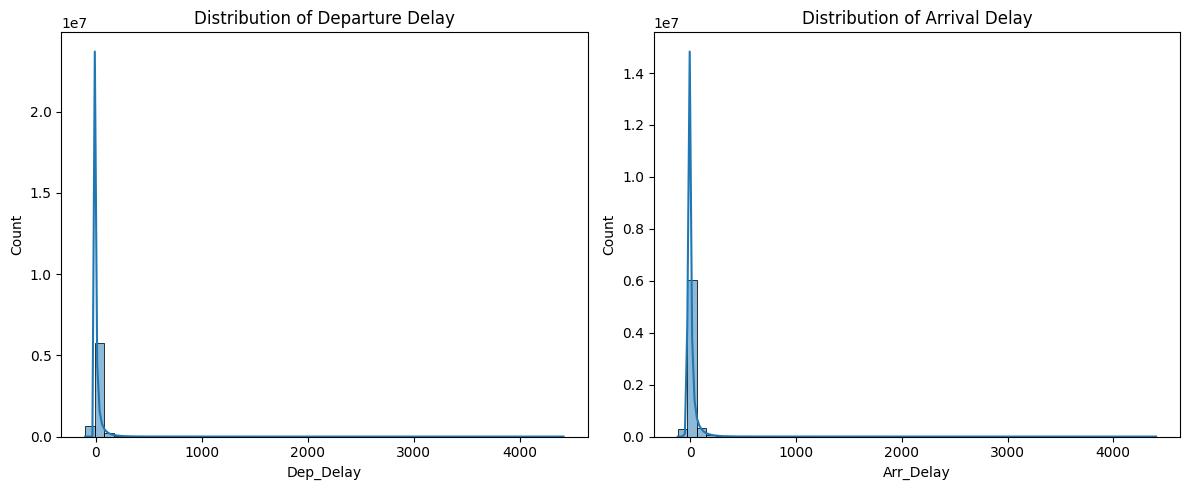

In [15]:
# Visualize distribution of target variables
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Dep_Delay'], bins=50, kde=True)
plt.title('Distribution of Departure Delay')
plt.subplot(1, 2, 2)
sns.histplot(df['Arr_Delay'], bins=50, kde=True)
plt.title('Distribution of Arrival Delay')
plt.tight_layout()
plt.show()

## Visualization for Insights

We create additional visualizations to understand the relationships between features and the target variables, as well as the model's performance.

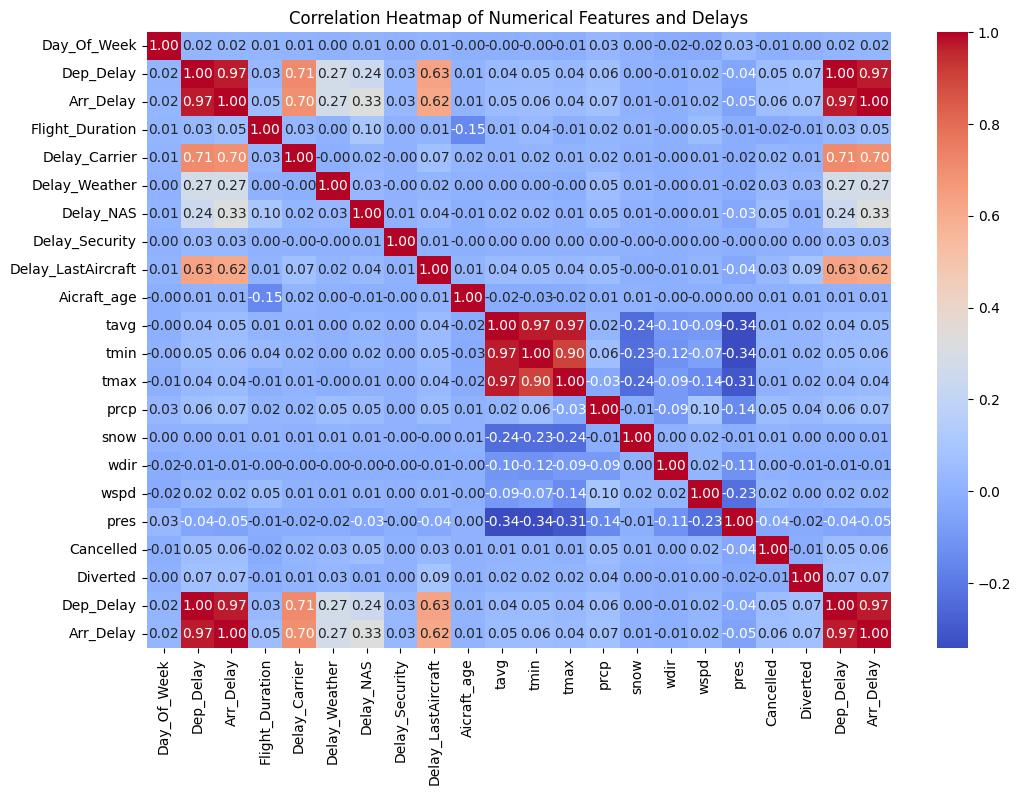

In [16]:
# Correlation heatmap for numerical features and targets
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist() + ['Dep_Delay', 'Arr_Delay']
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features and Delays')
plt.show()

## Data Preprocessing

We define the features and target variables, split the dataset into train, validation, and test sets, and set up a preprocessing pipeline.

In [17]:
# Defining the targets and features
targets = ['Dep_Delay', 'Arr_Delay']
features = [
    'Day_Of_Week', 'Airline', 'Dep_Airport', 'DepTime_label',
    'Flight_Duration', 'Distance_type', 'Delay_Carrier', 'Delay_Weather', 'Delay_NAS',
    'Delay_Security', 'Delay_LastAircraft', 'Manufacturer', 'Aicraft_age',
    'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres',
    'Aircraft_Age_Group'
]

# Drop missing target rows and shuffle
df = df.dropna(subset=targets).sample(frac=1, random_state=42).reset_index(drop=True)

# Splitting the dataset into 40% train, 40% val, 20% test
n = len(df)
train_df = df.iloc[:int(0.4 * n)]
val_df   = df.iloc[int(0.4 * n):int(0.8 * n)]
test_df  = df.iloc[int(0.8 * n):]

X_train, y_train = train_df[features], train_df[targets]
X_val, y_val     = val_df[features], val_df[targets]
X_test, y_test   = test_df[features], test_df[targets]

In [18]:
# Preprocessing pipeline
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Fitting and transforming the training data
print("⚙️ Preprocessing training data...")
X_train_processed = preprocessor.fit_transform(X_train)

⚙️ Preprocessing training data...


## Model Training

We train a linear regression model for each target variable (departure and arrival delays).

In [19]:
# Training models with a progress bar
models = {}
print("Training models...")
for target in tqdm(targets, desc="Training progress", unit="target"):
    model = LinearRegression()
    model.fit(X_train_processed, y_train[target])
    models[target] = model

Training models...


Training progress: 100%|██████████| 2/2 [01:16<00:00, 38.04s/target]


## Model Evaluation

We evaluate the models on the validation set using MAE, RMSE, and R² metrics.

In [20]:
# Validating models
print("\n📈 Validation Results:")
X_val_processed = preprocessor.transform(X_val)
for target in targets:
    y_pred = models[target].predict(X_val_processed)
    print(f"\n🔍 {target} Validation:")
    print(f"MAE:  {mean_absolute_error(y_val[target], y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y_val[target], y_pred):.2f}")
    print(f"R²:   {r2_score(y_val[target], y_pred):.2f}")


📈 Validation Results:

🔍 Dep_Delay Validation:
MAE:  6.81
RMSE: 107.38
R²:   0.96

🔍 Arr_Delay Validation:
MAE:  8.15
RMSE: 106.82
R²:   0.97


## Hyperparameter Tuning

To potentially improve model performance, we perform hyperparameter tuning using GridSearchCV. We tune the `fit_intercept` parameter of LinearRegression. Note: Polynomial features were initially considered but removed due to memory constraints and pickling issues on Windows when using parallel processing. We also run GridSearchCV sequentially (`n_jobs=1`) to avoid pickling errors.

In [21]:
from sklearn.model_selection import GridSearchCV

# Define the pipeline with linear regression (no polynomial features to reduce memory usage)
tuned_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Define parameter grid for tuning
param_grid = {
    'model__fit_intercept': [True, False]
}

# Perform grid search for each target
tuned_models = {}
print("Performing hyperparameter tuning...")
for target in tqdm(targets, desc="Tuning progress", unit="target"):
    grid_search = GridSearchCV(
        tuned_pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=1  # Run sequentially to avoid pickling issues
    )
    grid_search.fit(X_train, y_train[target])
    tuned_models[target] = grid_search.best_estimator_
    print(f"\n🔍 Best parameters for {target}:")
    print(grid_search.best_params_)
    print(f"Best MAE score: {-grid_search.best_score_:.2f}")

Performing hyperparameter tuning...


Tuning progress:  50%|█████     | 1/2 [07:49<07:49, 469.49s/target]


🔍 Best parameters for Dep_Delay:
{'model__fit_intercept': True}
Best MAE score: 6.81


Tuning progress: 100%|██████████| 2/2 [15:55<00:00, 477.88s/target]


🔍 Best parameters for Arr_Delay:
{'model__fit_intercept': True}
Best MAE score: 8.16


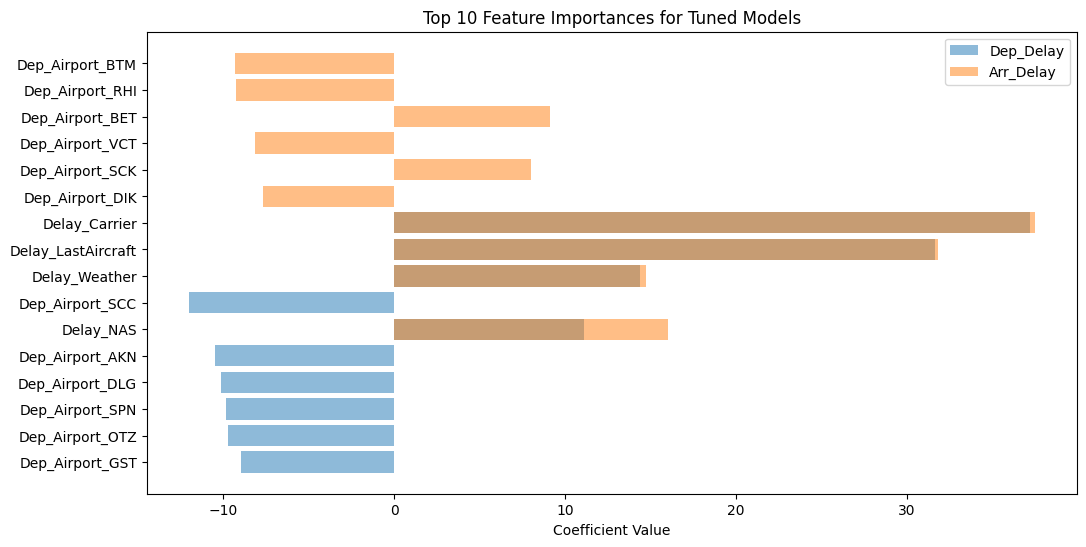

In [24]:
# Feature importance plot for tuned models
plt.figure(figsize=(12, 6))
for target in targets:
    # Extract coefficients from the tuned model
    coef = tuned_models[target].named_steps['model'].coef_
    feature_names = (numeric_features + 
                     tuned_models[target].named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features).tolist())
    # Select top 10 features by absolute coefficient value
    top_indices = np.argsort(np.abs(coef))[-10:]
    top_features = [feature_names[i] for i in top_indices]
    top_coefs = coef[top_indices]
    plt.barh(top_features, top_coefs, alpha=0.5, label=target)
plt.title('Top 10 Feature Importances for Tuned Models')
plt.xlabel('Coefficient Value')
plt.legend()
plt.show()

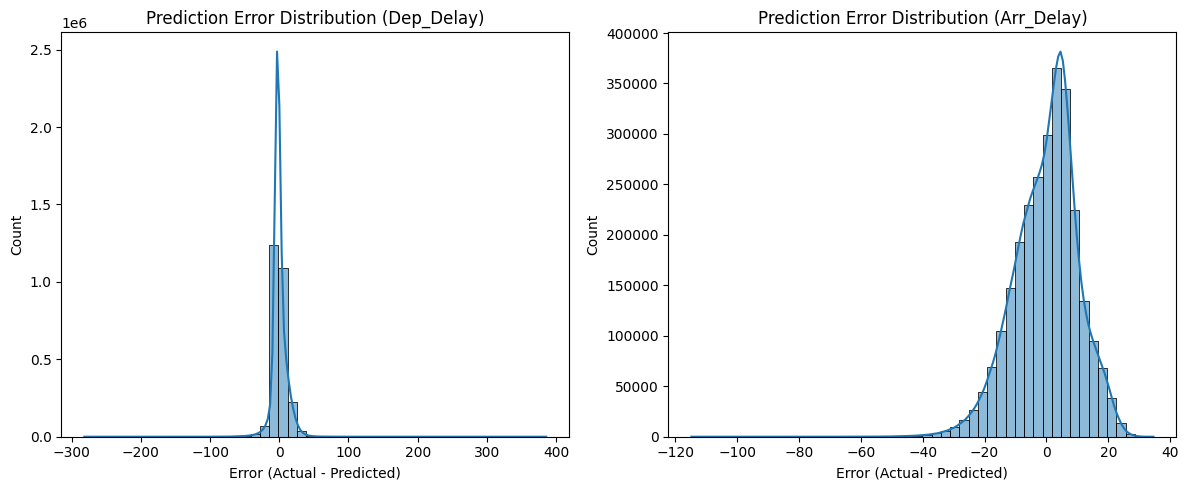

In [25]:
# Prediction error distribution for tuned models
plt.figure(figsize=(12, 5))
for i, target in enumerate(targets, 1):
    y_pred_tuned = tuned_models[target].predict(X_val)
    errors = y_val[target] - y_pred_tuned
    plt.subplot(1, 2, i)
    sns.histplot(errors, bins=50, kde=True)
    plt.title(f'Prediction Error Distribution ({target})')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Evaluating Tuned Models

We evaluate the tuned models on the validation set and compare their performance with the original models.

In [26]:
# Evaluate tuned models
print("\n📈 Tuned Model Validation Results:")
for target in targets:
    y_pred_tuned = tuned_models[target].predict(X_val)
    print(f"\n🔍 {target} Tuned Model Validation:")
    print(f"MAE:  {mean_absolute_error(y_val[target], y_pred_tuned):.2f}")
    print(f"RMSE: {mean_squared_error(y_val[target], y_pred_tuned):.2f}")
    print(f"R²:   {r2_score(y_val[target], y_pred_tuned):.2f}")


📈 Tuned Model Validation Results:

🔍 Dep_Delay Tuned Model Validation:
MAE:  6.81
RMSE: 107.38
R²:   0.96

🔍 Arr_Delay Tuned Model Validation:
MAE:  8.15
RMSE: 106.82
R²:   0.97


## Saving Models and Test Set

We save the preprocessor, models, and test set for future use.

In [ ]:
# Save model and preprocessor
print("\n💾 Saving models...")
os.makedirs("model", exist_ok=True)

with open("model/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

with open("model/flight_delay_model.pkl", "wb") as f:
    pickle.dump(models, f)

with open("model/tuned_flight_delay_model.pkl", "wb") as f:
    pickle.dump(tuned_models, f)

# Saving the test set for later evaluation
X_test.to_csv("model/X_test.csv", index=False)
y_test.to_csv("model/y_test.csv", index=False)

print("\nModels saved in 'model/' and test set stored for later evaluation.")

## Conclusion

We successfully built a pipeline to predict flight delays, including data preprocessing, model training, evaluation, and hyperparameter tuning. The tuned models were evaluated and saved for future use, alongside the test set for final evaluation.